Задача была мной интерпретирована как задача на анализ выживаемости или надёжности (survival analysis). То есть, буду рассчитывать, как различные факторы влияют на продолжительность работы оборудования и анализировать время до наступления аварии



# Импорт нужных библиотек

решение выполнялось в google colab, установим нужные пакеты и затем импорируем библиотеки

In [1]:
! pip install sklearn-pandas

In [2]:
pip install torchtuples

     |████████████████████████████████| 51kB 6.6MB/s 


In [3]:
!pip install pycox

     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 122kB 17.6MB/s 
     |████████████████████████████████| 1.9MB 9.8MB/s 
     |████████████████████████████████| 2.2MB 49.7MB/s 


In [100]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper 

In [5]:
import torch  
import torchtuples as tt 

In [6]:
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [7]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Загрузка и обработка данных

In [206]:
df_train = pd.read_excel('241-1.xlsx', skiprows=[1])

In [210]:
df_train.head()

,Date/Time,StuckPipe,TVD,DEPT,CDEPTH,HDTH,BPOS,HKLD,STOR,FLWI,RPM,SPPA,ECD,DLS,INCL,AZIM,GR,APRS,BVEL,RIG_STATE,Stick_Slip_Ratio,StickPercentage,ESD
0,1336036500000000000,0.0,1121.6945,4765.6821,4765.6821,6654.9971,22.4607,59.4070,30.78,4002.3162,81.56,22020.4766,-999.2500,0.0492,82.68,86.80,-999.25,-999.2500,-35.1472,7,-999.25,-999.25,-999.25
1,1336036510000000000,0.0,1121.6792,4765.5723,4765.5723,6654.9971,22.5674,59.9649,30.60,4006.0259,81.56,22030.4043,1.4271,0.0492,82.69,86.80,139.41,15644.2041,-39.5407,7,-999.25,-999.25,-999.25
2,1336036520000000000,0.0,1121.6670,4765.4717,4765.4717,6654.9971,22.6680,59.4932,31.44,4003.1868,81.56,22038.9531,-999.2500,0.0492,82.69,86.81,145.60,-999.2500,-36.2188,7,-999.25,-999.25,-999.25
3,1336036530000000000,0.0,1121.6549,4765.3711,4765.3711,6654.9971,22.7686,59.1394,30.77,4003.0732,81.56,22029.5762,-999.2500,0.0492,82.69,86.81,-999.25,-999.2500,-36.2188,7,-999.25,-999.25,-999.25
4,1336036540000000000,0.0,1121.6396,4765.2646,4765.2646,6654.9971,22.8783,58.5406,30.80,4006.4043,81.56,22024.0605,-999.2500,0.0492,82.69,86.81,145.60,-999.2500,-38.3619,7,-999.25,-999.25,-999.25


In [208]:
#заменяем все None нулями
df_train.fillna(0, inplace = True)

In [209]:
#сконвертируем в integer дату, в EvalSurv не подходит datatime
df_train['Date/Time'] = df_train['Date/Time'].apply(lambda x: x.value)

In [211]:
#сохраним получившийся датасет в файл
df_train.to_csv('df.csv', index=False)

разделим обновленный датасет на обучающую, тестовую и валидационную выборки

In [212]:
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Поскольку ни для одного из показателей распределение не совсем похоже на Гауссово (гистограмма не всегда похожа на колокол) - значит StandardScaler не совсем подойдет, но и выбросов нет, соответственно и не нужно использовать RobustScalar, поэтому будем использовать MinMaxScalar для нормализации признаков

Порядок действий такой

- Сначала выборка делится на тренировочную, валидационную и тестовую.
- Для получения масштабированной тренировочной выборки к ней применяется метод fit_transform. Он последовательно выполняет fit (устанавливает параметры скейлера), и применяет скейлер уже с этими параметрами к предоставленным данным (transform). 
- А к тестовой и валидационной выборкам мы применяем метод transform. Иначе параметры скейлера будут выставлены для тестовой выборки.

Основываясь на полученной информации о данных, примем решение стандартизировать большинство из признаков

In [213]:
cols_standardize = ['TVD', 'DEPT', 'CDEPTH', 'HDTH', 'BPOS',
       'HKLD', 'STOR', 'FLWI', 'RPM', 'SPPA', 'ECD', 'INCL', 'AZIM',
       'GR', 'APRS', 'BVEL', 'RIG_STATE', 'Stick_Slip_Ratio',
       'StickPercentage', 'ESD']
cols_leave = ['DLS']

standardize = [([col], MinMaxScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [214]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# Кодирование меток
Анализ выживания требует индивидуального преобразования меток.

Использовала LogisticHazard - это метод с дискретным временем. Num_durations определяет размер этой сетки дискретизации.

In [215]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['StuckPipe'].values, df['Date/Time'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

durations_test, events_test = get_target(df_test)

In [216]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

Labtrans.cuts содержит сетку дискретизации. Будет использоваться для получения правильной шкалы времени для прогнозов выживаемости.

In [217]:
labtrans.cuts

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

Теперь y_train - это кортеж с индексами дискретизированного времени в дополнение к индикаторам событий.


In [218]:
y_train

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,
        9, 9, 9, 9]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
    

In [219]:
labtrans.cuts[y_train[0]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1.])

# Нейронная сеть
Для тестового задания будем использовать MLPVanilla из torchtuples. В качестве точки роста можно будет создать более продвинутые нейросети 

In [220]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

## Обучаем модель

In [221]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [222]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [223]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.8717,	val_loss: 0.8926
1:	[0s / 0s],		train_loss: 0.7801,	val_loss: 0.8261
2:	[0s / 0s],		train_loss: 0.6918,	val_loss: 0.7764
3:	[0s / 0s],		train_loss: 0.6363,	val_loss: 0.7276
4:	[0s / 0s],		train_loss: 0.5926,	val_loss: 0.6744
5:	[0s / 0s],		train_loss: 0.5642,	val_loss: 0.6214
6:	[0s / 0s],		train_loss: 0.5257,	val_loss: 0.5672
7:	[0s / 0s],		train_loss: 0.4978,	val_loss: 0.5161
8:	[0s / 0s],		train_loss: 0.4776,	val_loss: 0.4701
9:	[0s / 0s],		train_loss: 0.4585,	val_loss: 0.4297
10:	[0s / 0s],		train_loss: 0.4162,	val_loss: 0.3924
11:	[0s / 0s],		train_loss: 0.3974,	val_loss: 0.3561
12:	[0s / 0s],		train_loss: 0.3698,	val_loss: 0.3196
13:	[0s / 0s],		train_loss: 0.3492,	val_loss: 0.2861
14:	[0s / 0s],		train_loss: 0.3272,	val_loss: 0.2572
15:	[0s / 0s],		train_loss: 0.2903,	val_loss: 0.2275
16:	[0s / 0s],		train_loss: 0.2635,	val_loss: 0.1978
17:	[0s / 0s],		train_loss: 0.2580,	val_loss: 0.1724
18:	[0s / 0s],		train_loss: 0.2321,	val_loss: 0.1497
19:

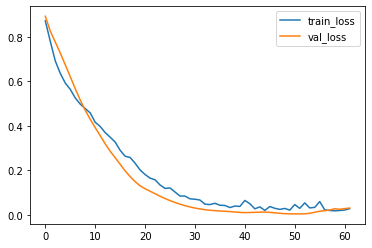

In [224]:
_ = log.plot()

После завершения колбек EarlyStopping загружает наиболее эффективную модель (с точки зрения ошибки). 

In [225]:
log.to_pandas().val_loss.min()

0.004347871523350477

In [226]:
model.score_in_batches(val)

{'loss': 0.004347871523350477}


## Предсказываем
Сначала предскажем выживаемость для тестовой выборки

In [227]:
surv = model.predict_surv_df(x_test)

Выведем на график оценки выживаемости для первых 5 наблюдений

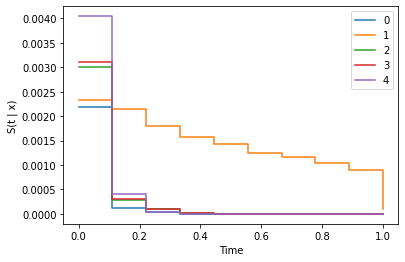

In [228]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

Проинтерполируем оценки выживаемости. Заменим по 10 точек каждой точкой сетки.

In [229]:
surv = model.interpolate(10).predict_surv_df(x_test)

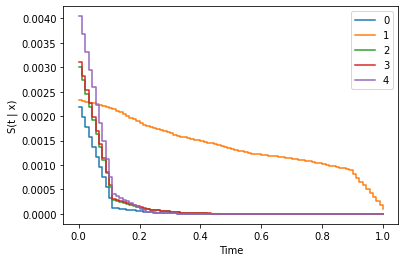

In [230]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Оценка
Класс EvalSurv содержит некоторые полезные критерии оценки для прогнозирования времени до события. Мы устанавливаем censor_surv = 'km', то есть будем использовать методология Каплана-Мейера для описания функции выживания. Этот метод позволяет сравнивать функции выживания между собой, чтобы определить есть ли между ними статистически-значимая разница

In [233]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#Сoncordance index
Полученная модель демонстрирует следующие значения concordance index (индекс соответствия), который используется для измерения того, насколько хорошо модель предсказывает время до события.

In [ ]:
ev.concordance_td('antolini')

Результат слишком хороший, это подтверждает выводы, сделанные в задании 2 о том, что несбалансированность классов приводит к неэффективности модели